In [1]:
# import modules
#People that I completed this assingment with Jimmy Lilly, Madison Walder, Mackenzie James, Ryan Webster
import numpy as np
import astropy.units as u
import astropy.table as tbl
from astropy.constants import G
import matplotlib
import matplotlib.pyplot as plt

from ReadFile import Read
from CenterOfMass import CenterOfMass

0.0 Myr
135000
(1., 0.00394985, -286.601, 298.455, 391.692, 50.2658, -46.4521, 15.1825)
1.0
MW
[-2.07  2.95 -1.45] kpc
[ 0.94  6.32 -1.35] km / s
M31
[-377.66  611.43 -284.64] kpc
[ 72.85 -72.14  49.  ] km / s
M33
[-476.22  491.44 -412.4 ] kpc
[ 44.42 101.78 142.23] km / s
769.098 kpc
117.738 km / s
201.083 kpc
199.37 km / s


In [2]:
class MassProfile:
    #class to define the mass profile
    def __init__(self, galaxy, snap):  
        # Make it easier to call file names with different snapshots
        ilbl = '000'+ str(snap)
        ilbl = ilbl[-3:] #remove last three lines
        
        self.filename= "%s_"%(galaxy) + ilbl + '.txt'
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             


        # store the mass, positions of the all particles
        self.m = self.data['m']
        self.x = self.data['x']*u.kpc
        self.y = self.data['y']*u.kpc
        self.z = self.data['z']*u.kpc
        
        #store the name of galaxy
        self.gname= galaxy
        
    def MassEnclosed(self, ptype, radius):
        #Inputs: Particle type and radii
        #Returns: array of Masses
        
        #create an index
        index = np.where(self.data['type'] == ptype)
        
        #store x,y,z,m components of particle type
        x2=self.x[index]
        y2=self.y[index]
        z2=self.z[index]
        m2=self.m[index]
        
        
        #find the COM (delta=0.1 for comp_p)
        COM= CenterOfMass(self.filename, ptype)
        COMP= COM.COM_P(0.1)
        
        #store the center of mass components
        XCOM=COMP[0]
        YCOM=COMP[1]
        ZCOM=COMP[2]
        
        #find the radius of the particle
        RCOM=np.sqrt((x2-XCOM)**2+(y2-YCOM)**2+(z2-ZCOM)**2)
        
        #initialize mass
        Enclosedmass=np.zeros(len(radius))
        
        #for loop over the radii 
        for i in range(len(radius)):
            
            #make an index for all particles within the radius given
            indexnew=np.where(RCOM <= radius[i])
            
            #store all the mass values and add them up to get the total mass within a certain radius
            Enclosedmass[i]=np.sum(m2[indexnew])
        
        return Enclosedmass*1e10*u.Msun
    
    def MassEnclosedTotal(self, radii):
        #function to get the total mass enclosed of all particle types
        #inputs: radii= distance from COM
        #returns: total mass enclosed of Disk, Halo, and bulge
        
        #since M33 has no bulge we need to only add halo and disk
        if self.gname=='M33':
            HaloMass=self.MassEnclosed(1,radii)
            DiskMass=self.MassEnclosed(2,radii)
            BulgeMass=np.zeros(len(radii))
            
        else:
            #For MW and M31 they both have bulges so use the MassEnclosed funtion to find bulge mass
            HaloMass=self.MassEnclosed(1,radii)
            DiskMass=self.MassEnclosed(2,radii)
            BulgeMass=self.MassEnclosed(3,radii)
            
        #add up all masses to get total enclosed mass    
        MassEnclosedTot=HaloMass+DiskMass+BulgeMass
        
        return MassEnclosedTot
    
    #create a function that returns the Hernquist 1990 Mass Profile
    def HernquistM(self,r,HaloMass,a):
        #inputs:
        #   r is the distance from the center of the galaxy (kpc)
        #   a is the scale radius (kpc)
        #   Mhalo is the total dark matter halo mass (10^12Msun)
        #return:
        #   total dark mass enclosed within r (Msun)
        return HaloMass*r**2/(a+r)**2*1e12*u.Msun
    
    #Create a function that calculates the circular velocity V=sqrt(GM/R) using mass enclosed at each radius
    def CircularVelocity(self, ptype, radii):
        #inputs:
        #parttype = particle type 
        #radii = a radom radius user inputs manually 
        #Returns:
        #Array of circular speeds rounded to two decimal places (km/s)
        
        #need to convert G
        Gupdated = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        
        #need to get Mass, which is already calculated in Mass Enclosed function
        M=self.MassEnclosed(ptype,radii)
        
        
        #calculate circular velocity V=sqrt(GM/R) using F=ma where a is v^2/r and F is GM^2/R^2
        CircV=np.round(np.sqrt((Gupdated*M)/radii),2)
        
        return CircV #units of (km/s)
    
    #create a function to calculate the total circular velocity of all compontents  (bulge, diks,halo) 
    def CircularVelocityTotal(self, radii):
        #inputs:
        #radii= a radom radius the user inputs
        #returns:
        #array of total circular velocity of all components (bulge, diks,halo)
        
        #use MassEnclosedTotal mass to get the total mass enclosed a given radius
        MassEnc=self.MassEnclosedTotal(radii)
        
        #need to convert G
        Gupdated2 = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        
        #calculate Vcirctot
        
        VcircTot=np.round(np.sqrt((Gupdated2*MassEnc)/radii),2)
        
        return VcircTot
    
    #create a function to caluclate Vcirc but using the hernquist mass profile
    def HernquistVCirc(self,radii, Mhalo, a):
        #inputs:
        #   r is the distance from the center of the galaxy (kpc)
        #   a is the scale radius (kpc)
        #   Mhalo is the total dark matter halo mass (10^12Msun)
        #return:
        #   total circular speed within r (km/s)
         
        #need to convert G
        Gupdated3 = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
        
        #call herquist mass
        M=self.HernquistM(radii,Mhalo,a)
        
        #calculate Vcirc
        HernCircV=np.round(np.sqrt((Gupdated3*M)/radii),2)
        
        return HernCircV
        
    
        
        
            
        
        
    
        
    



In [3]:
#initialize all the files and get all the data ready for the rest of the code
MW= MassProfile("MW",0)
M31= MassProfile("M31",0)
M33= MassProfile("M33",0)

In [8]:
R=
MW_Enc=MW.MassEnclosed(2,R)
MW_Enc

TypeError: object of type 'int' has no len()

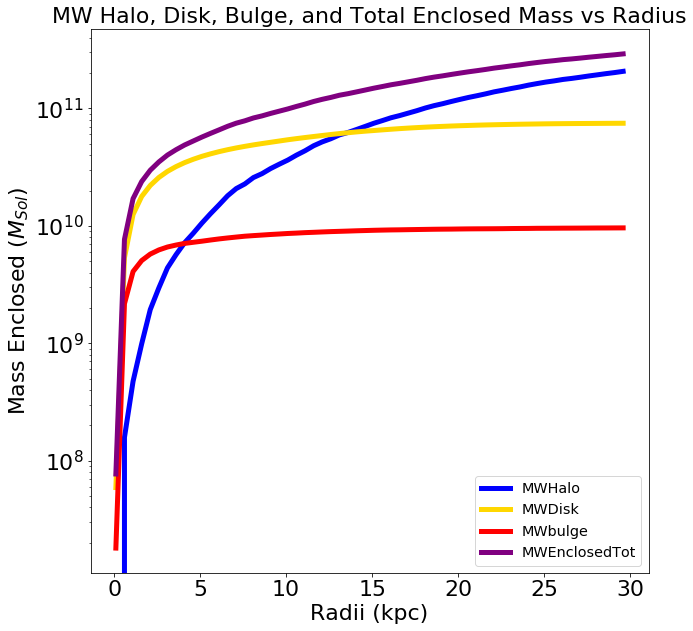

In [45]:
# Plot the MassEnclosed Function Vs Radius for MW

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Mass on y (y axis log, use semilogy)
ax.semilogy(R,MW.MassEnclosed(1,R),color='blue', linewidth=5, label='MWHalo')
ax.semilogy(R,MW.MassEnclosed(2,R),color='gold', linewidth=5, label='MWDisk')
ax.semilogy(R,MW.MassEnclosed(3,R),color='red', linewidth=5, label='MWbulge')
ax.semilogy(R,MW.MassEnclosedTotal(R),color='purple', linewidth=5, label='MWEnclosedTot')

# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Mass Enclosed ($M_{Sol}$)', fontsize=22)
plt.title(r'MW Halo, Disk, Bulge, and Total Enclosed Mass vs Radius',fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

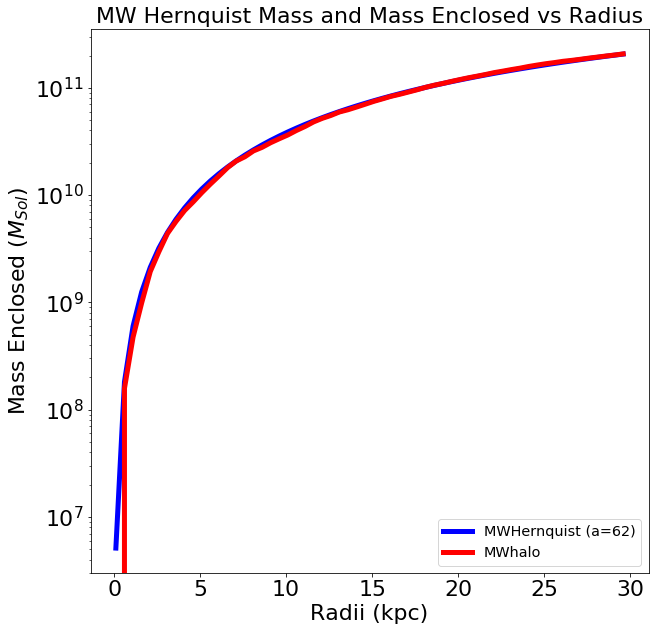

In [46]:
#plot halo mass using hernquist function and then compare to mass enclosed function for MW

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Mass on y (y axis log, use semilogy)
#use halomass from homework 3 table and change a until the curves relativly match
ax.semilogy(R,MW.HernquistM(R,HaloMass=1.975,a=62*u.kpc),color='blue', linewidth=5, label='MWHernquist (a=62)')
ax.semilogy(R,MW.MassEnclosed(1,R),color='red', linewidth=5, label='MWhalo')


# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Mass Enclosed ($M_{Sol}$)', fontsize=22)
plt.title(r'MW Hernquist Mass and Mass Enclosed vs Radius',fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

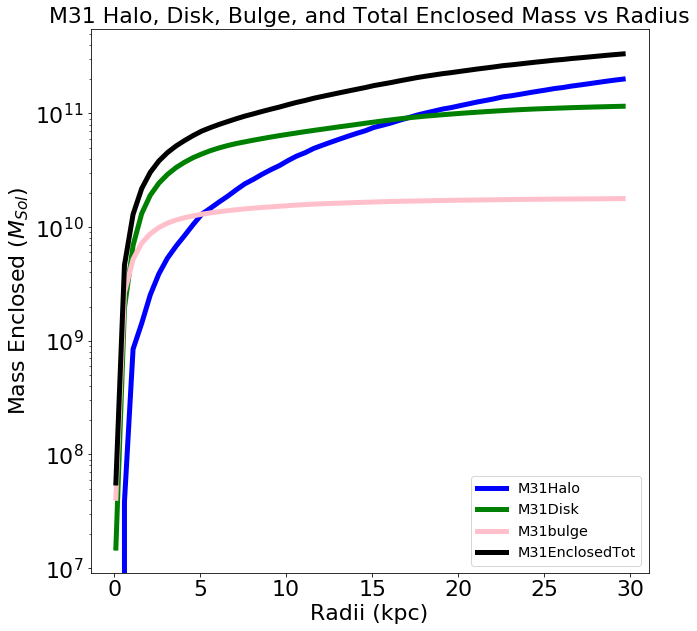

In [47]:
# Plot the MassEnclosed Function Vs Radius for M31

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Mass on y (y axis log, use semilogy)
ax.semilogy(R,M31.MassEnclosed(1,R),color='blue', linewidth=5, label='M31Halo')
ax.semilogy(R,M31.MassEnclosed(2,R),color='green', linewidth=5, label='M31Disk')
ax.semilogy(R,M31.MassEnclosed(3,R),color='pink', linewidth=5, label='M31bulge')
ax.semilogy(R,M31.MassEnclosedTotal(R),color='black', linewidth=5, label='M31EnclosedTot')

# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Mass Enclosed ($M_{Sol}$)', fontsize=22)
plt.title(r'M31 Halo, Disk, Bulge, and Total Enclosed Mass vs Radius',fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

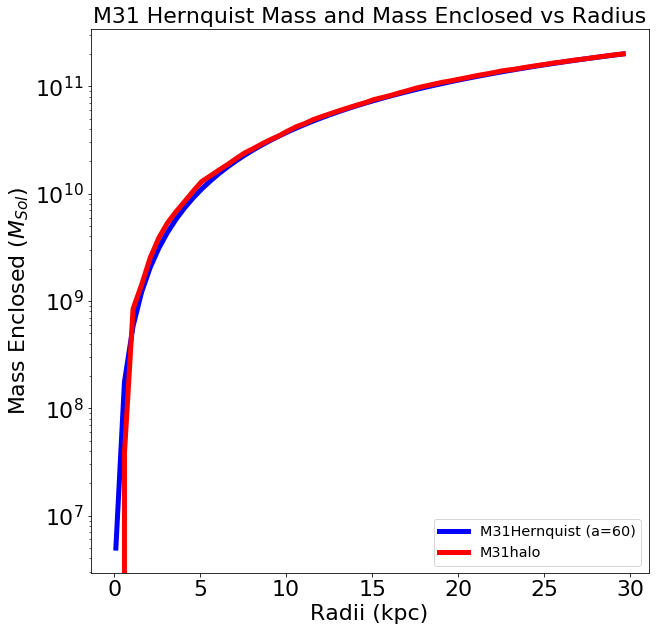

In [48]:
#plot halo mass using hernquist function and then compare to mass enclosed function for M31

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Mass on y (y axis log, use semilogy)
#use halomass from homework 3 table and change a until the curves relativly match
ax.semilogy(R,M31.HernquistM(R,HaloMass=1.921,a=62*u.kpc),color='blue', linewidth=5, label='M31Hernquist (a=60)')
ax.semilogy(R,M31.MassEnclosed(1,R),color='red', linewidth=5, label='M31halo')


# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Mass Enclosed ($M_{Sol}$)', fontsize=22)
plt.title(r'M31 Hernquist Mass and Mass Enclosed vs Radius',fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

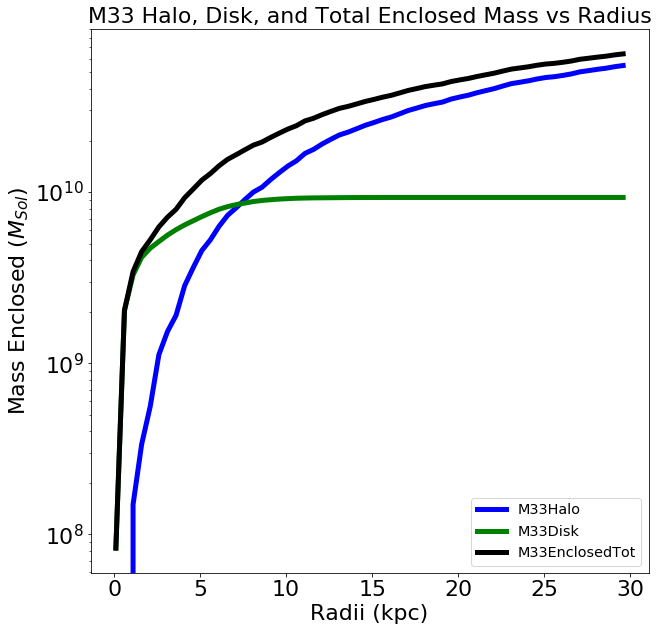

In [50]:
# Plot the MassEnclosed Function Vs Radius for M33

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Mass on y (y axis log, use semilogy)
ax.semilogy(R,M33.MassEnclosed(1,R),color='blue', linewidth=5, label='M33Halo')
ax.semilogy(R,M33.MassEnclosed(2,R),color='green', linewidth=5, label='M33Disk')

#there is no bulge mass for M33 so it is not plotted 

ax.semilogy(R,M33.MassEnclosedTotal(R),color='black', linewidth=5, label='M33EnclosedTot')

# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Mass Enclosed ($M_{Sol}$)', fontsize=22)
plt.title(r'M33 Halo, Disk, and Total Enclosed Mass vs Radius',fontsize=22)



#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

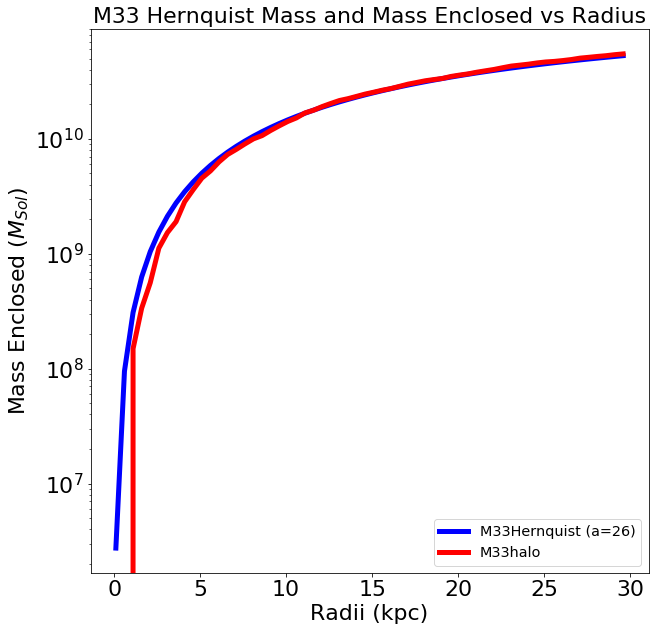

In [16]:
#plot halo mass using hernquist function and then compare to mass enclosed function for M33

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Mass on y (y axis log, use semilogy)
#use halomass from homework 3 table and change a until the curves relativly match
ax.semilogy(R,M33.HernquistM(R,HaloMass=0.187,a=26*u.kpc),color='blue', linewidth=5, label='M33Hernquist (a=26)')
ax.semilogy(R,M33.MassEnclosed(1,R),color='red', linewidth=5, label='M33halo')


# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Mass Enclosed ($M_{Sol}$)', fontsize=22)
plt.title(r'M33 Hernquist Mass and Mass Enclosed vs Radius',fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

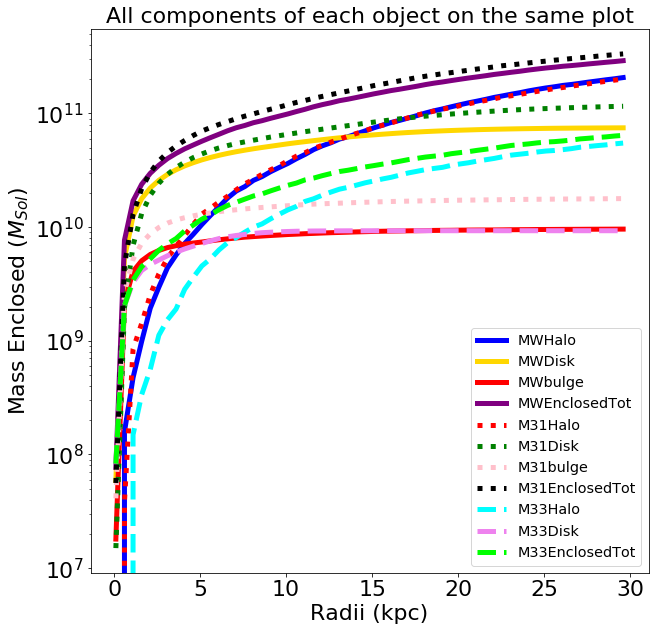

In [12]:
# Plot the MassEnclosed Function Vs Radius for MW

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Mass on y (y axis log, use semilogy)
ax.semilogy(R,MW.MassEnclosed(1,R),color='blue', linewidth=5, label='MWHalo')
ax.semilogy(R,MW.MassEnclosed(2,R),color='gold', linewidth=5, label='MWDisk')
ax.semilogy(R,MW.MassEnclosed(3,R),color='red', linewidth=5, label='MWbulge')
ax.semilogy(R,MW.MassEnclosedTotal(R),color='purple', linewidth=5, label='MWEnclosedTot')
ax.semilogy(R,M31.MassEnclosed(1,R),color='red', linewidth=5, linestyle=':', label='M31Halo')
ax.semilogy(R,M31.MassEnclosed(2,R),color='green', linewidth=5, linestyle=':', label='M31Disk')
ax.semilogy(R,M31.MassEnclosed(3,R),color='pink', linewidth=5, linestyle=':', label='M31bulge')
ax.semilogy(R,M31.MassEnclosedTotal(R),color='black', linewidth=5, linestyle=':', label='M31EnclosedTot')
ax.semilogy(R,M33.MassEnclosed(1,R),color='cyan', linewidth=5, linestyle='--', label='M33Halo')
ax.semilogy(R,M33.MassEnclosed(2,R),color='violet', linewidth=5, linestyle='--', label='M33Disk')
ax.semilogy(R,M33.MassEnclosedTotal(R),color='lime', linewidth=5, linestyle='--', label='M33EnclosedTot')

# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Mass Enclosed ($M_{Sol}$)', fontsize=22)
plt.title(r'All components of each object on the same plot',fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

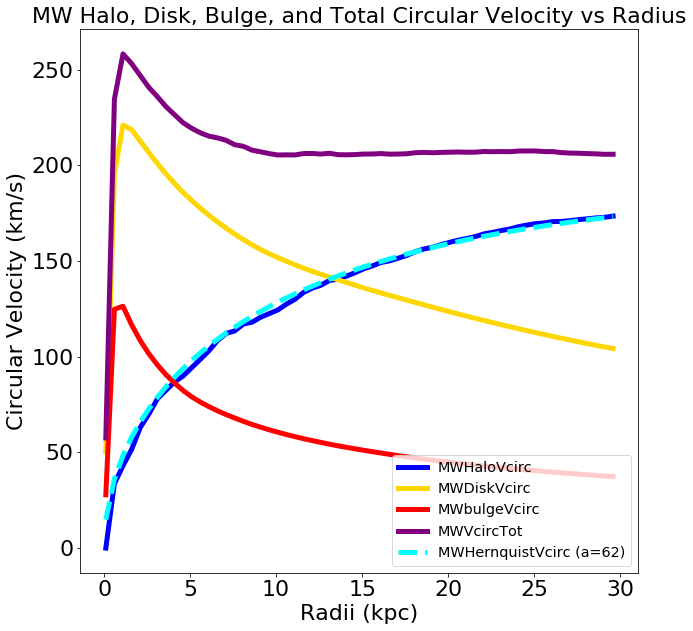

In [54]:
# Plot the Circular Velocity Function Vs Radius for MW

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Circular Velocity on y (y axis log, use semilogy)
ax.plot(R,MW.CircularVelocity(1,R),color='blue', linewidth=5, label='MWHaloVcirc')
ax.plot(R,MW.CircularVelocity(2,R),color='gold', linewidth=5, label='MWDiskVcirc')
ax.plot(R,MW.CircularVelocity(3,R),color='red', linewidth=5, label='MWbulgeVcirc')
ax.plot(R,MW.CircularVelocityTotal(R),color='purple', linewidth=5, label='MWVcircTot')
ax.plot(R,MW.HernquistVCirc(R,Mhalo=1.975,a=62*u.kpc),color='cyan', linewidth=5, linestyle='--', label='MWHernquistVcirc (a=62)')



# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Circular Velocity (km/s)', fontsize=22)
plt.title(r'MW Halo, Disk, Bulge, and Total Circular Velocity vs Radius',fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

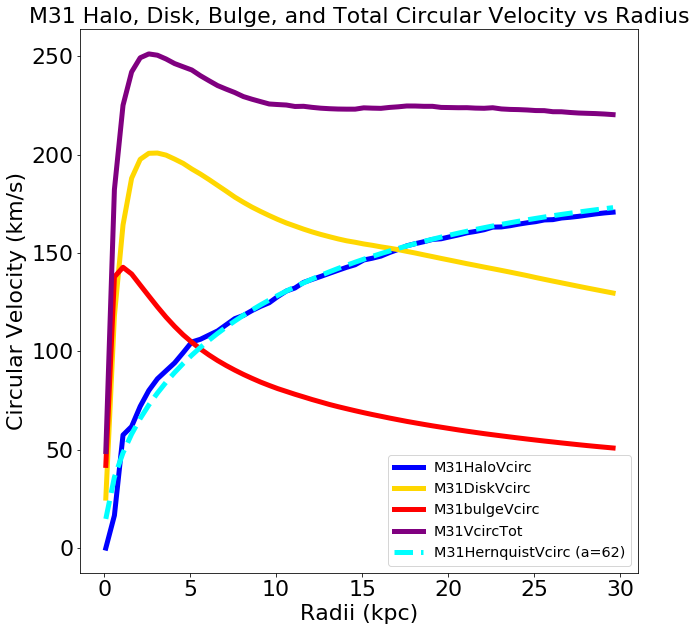

In [55]:
# Plot the Circular Velocity Function Vs Radius for MW31

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Circular Velocity on y 
ax.plot(R,M31.CircularVelocity(1,R),color='blue', linewidth=5, label='M31HaloVcirc')
ax.plot(R,M31.CircularVelocity(2,R),color='gold', linewidth=5, label='M31DiskVcirc')
ax.plot(R,M31.CircularVelocity(3,R),color='red', linewidth=5, label='M31bulgeVcirc')
ax.plot(R,M31.CircularVelocityTotal(R),color='purple', linewidth=5, label='M31VcircTot')
ax.plot(R,M31.HernquistVCirc(R,Mhalo=1.975,a=62*u.kpc),color='cyan', linewidth=5, linestyle='--', label='M31HernquistVcirc (a=62)')



# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Circular Velocity (km/s)', fontsize=22)
plt.title(r'M31 Halo, Disk, Bulge, and Total Circular Velocity vs Radius',fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

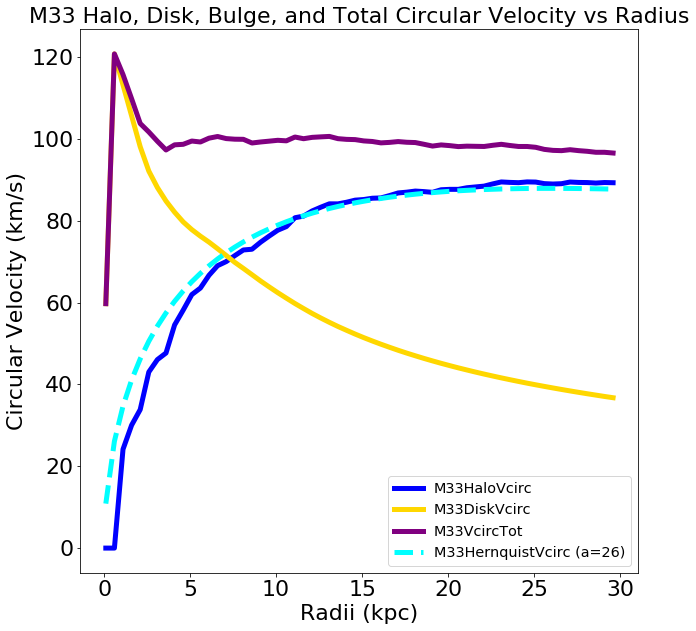

In [21]:
# Plot the Circular Velocity Function Vs Radius for M33

R=np.arange(0.1,30,0.5)*u.kpc

fig = plt.figure(figsize=(10,10))  # sets the scale of the figure
ax = plt.subplot(111) 

# Plot the radii as x and Circular Velocity on y
ax.plot(R,M33.CircularVelocity(1,R),color='blue', linewidth=5, label='M33HaloVcirc')
ax.plot(R,M33.CircularVelocity(2,R),color='gold', linewidth=5, label='M33DiskVcirc')

#M33 has no bulge mass so there is no circular velocity and is not plotted

ax.plot(R,M33.CircularVelocityTotal(R),color='purple', linewidth=5, label='M33VcircTot')
ax.plot(R,M33.HernquistVCirc(R,Mhalo=0.187,a=26*u.kpc),color='cyan', linewidth=5, linestyle='--', label='M33HernquistVcirc (a=26)')



# Add labels
plt.xlabel(r'Radii (kpc)', fontsize=22)
plt.ylabel(r'Circular Velocity (km/s)', fontsize=22)
plt.title(r'M33 Halo, Disk, Bulge, and Total Circular Velocity vs Radius',fontsize=22)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')